Saving input image 2.jpg to input image 2 (1).jpg
Detected: person with confidence 0.96
Detected: bottle with confidence 0.72
Detected: dining table with confidence 0.74
Detected: person with confidence 0.99
Detected: teddy bear with confidence 1.00
Detected: person with confidence 0.96
Detected: bottle with confidence 0.86


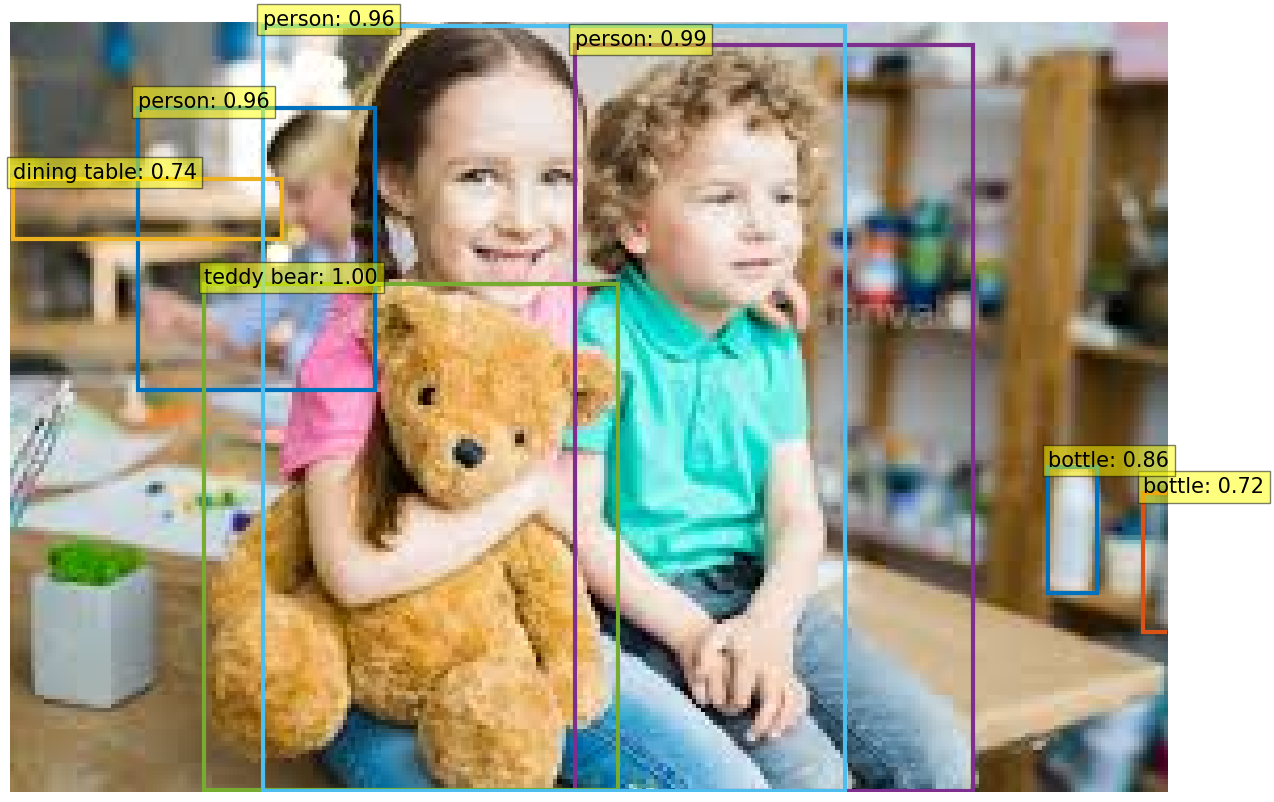

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
# Instead of using tkinter file dialog, use the following:
from google.colab import files

# Load image using google.colab.files
def load_image():
    uploaded = files.upload()
    for fn in uploaded.keys():
        # Validate the file type (optional)
        if not fn.lower().endswith(('.jpg', '.jpeg', '.png')):
            raise ValueError(f"Invalid file type: {fn}. Please upload a JPG, JPEG, or PNG image.")
        return Image.open(fn)
    raise ValueError("No file uploaded.") # Raise error if no file is uploaded


# Define DETR demo model
class DETRdemo(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()
        self.backbone = resnet50()
        del self.backbone.fc
        self.conv = nn.Conv2d(2048, hidden_dim, 1)
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        h = self.conv(x)
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

# Load pre-trained model
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval()

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Transform
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    img = transform(im).unsqueeze(0)
    outputs = model(img)
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        print(f"Detected: {CLASSES[cl]} with confidence {p[cl]:.2f}")
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Run
try:
    im = load_image()
    scores, boxes = detect(im, detr, transform)
    plot_results(im, scores, boxes)
except ValueError as e:
    print(e)

In [10]:
import random

def get_object_detail(object_name):
  """Provides a detail about the object."""
  # Add more object-specific details as needed
  if object_name == "person":
    return "with a curious gaze"
  elif object_name == "bottle":
    return "gleaming in the sunlight"
  elif object_name == "chair":
    return "standing invitingly"
  else:
    return "of unknown origin"

def get_object_action(object_name):
  """Provides an action related to the object."""
  # Add more object-specific actions as needed
  if object_name == "person":
    return "walking briskly"
  elif object_name == "bottle":
    return "reflecting the light"
  elif object_name == "chair":
    return "waiting patiently"
  else:
    return "doing something mysterious"

def generate_concise_story(detected_objects):
    """Generates a concise story (7-8 lines) based on detected objects.

    Args:
        detected_objects (list): A list of detected object names.
    """

    if not detected_objects:
        return "The image was a blank page, a story yet to be written. " \
               "No characters or plot appeared, only the whisper of untold possibilities."

    # Select a few objects for the story
    num_objects_in_story = min(4, len(detected_objects))  # Reduced to 4 for brevity
    selected_objects = random.sample(detected_objects, num_objects_in_story)

    # Create a concise story structure
    story_lines = [
        f"A {selected_objects[0]}, {get_object_detail(selected_objects[0])} ventured into the unknown.",
        f"It crossed paths with a {selected_objects[1]}, {get_object_detail(selected_objects[1])} sparking a moment of curiosity.",
        f"Together, they witnessed a {selected_objects[2]} {get_object_action(selected_objects[2])}",
        f"A {selected_objects[3] if num_objects_in_story > 3 else 'mystery'} emerged, adding intrigue to their journey.",  # Optional 4th object
        f"The {selected_objects[0]} and the {selected_objects[1]} faced a challenge,",
        f"but with courage and wit, they overcame the obstacle.",
        f"Their adventure continued, leaving behind a trail of wonder and excitement."  # Concluding line
    ]

    return "\n".join(story_lines)  # Join lines with newline for better formatting

# ... (Rest of the code remains the same) ...
# ... (get_object_detail and get_object_action functions remain the same) ...

# After running the object detection code:
# ... (Previous code for object detection) ...

# Get detected objects
detected_objects = [CLASSES[cl] for cl in scores.argmax(dim=1).tolist()]

# Generate and print the story
story = generate_concise_story(detected_objects)
print("\nHere's a concise story based on the image:")
print(story)


Here's a concise story based on the image:
A dining table, of unknown origin ventured into the unknown.
It crossed paths with a teddy bear, of unknown origin sparking a moment of curiosity.
Together, they witnessed a person walking briskly
A bottle emerged, adding intrigue to their journey.
The dining table and the teddy bear faced a challenge,
but with courage and wit, they overcame the obstacle.
Their adventure continued, leaving behind a trail of wonder and excitement.
